In [1]:
import association_metrics as am

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import scipy.stats as scs

import seaborn as sns

# Functions

In [2]:
def detect_outliers_iqr(df: pd.DataFrame, column: str):
    """
    Detects outliers in a specific column of a DataFrame using the IQR method.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column (str): The column name for which to detect outliers.
    
    Returns:
    dict: A dictionary containing the number of outliers and the outlier values.
    """
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # Compute the IQR
    IQR = Q3 - Q1
    
    # Define the outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    
    # Return the number of outliers and the actual outlier values
    result = {
        'number_of_outliers': outliers.shape[0],
        'outliers': outliers
    }
    
    return result


In [3]:
import pandas as pd

def check_nulls(df: pd.DataFrame, column: str):
    """
    Checks for NULL (NaN) values in a specific column of a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column (str): The column name for which to check for NULL values.
    
    Returns:
    dict: A dictionary containing the number of NULL values and their row indices and values.
    """
    # Identify NULL values in the column
    null_values = df[df[column].isnull()][column]
    
    # Return the number of NULL values, their indices, and values (which will be NaN)
    result = {
        'number_of_nulls': null_values.shape[0],
        'null_indices': null_values.index.tolist(),
        'null_values': null_values
    }
    
    return result

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

def feature_correlation(df: pd.DataFrame, threshold: float = 0.8):
    """
    Computes and visualizes the correlation matrix for features, and identifies highly correlated pairs.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    threshold (float): The threshold for considering features as highly correlated.
    
    Returns:
    pd.DataFrame: A DataFrame showing highly correlated feature pairs with correlation > threshold.
    """
    # Calculate correlation matrix for numerical columns
    corr_matrix = df.corr()
    
    # Visualize the correlation matrix as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Correlation Matrix of Features")
    plt.show()

    # Find highly correlated feature pairs
    correlated_pairs = (corr_matrix
                        .stack()  # Converts to long format
                        .reset_index()
                        .rename(columns={0: 'correlation'})
                        .query(f'abs(correlation) > {threshold} and level_0 != level_1')
                        .sort_values(by='correlation', ascending=False))

    return correlated_pairs

# Example of usage
# correlated_features = feature_correlation(df, threshold=0.8)
# print("Highly correlated feature pairs:")
# print(correlated_features)


# Import Data

In [5]:
# Load in Application Sample data

applications_df = pd.read_csv('../application_samples.csv')

In [6]:
applications_df.head()

,UID,ApplicationDate,Amount,Term,EmploymentType,LoanPurpose,Success
0,4921736,03/07/2020,2000,60,Employed - full time,Unexpected bills,0
1,1241981,04/02/2020,3000,60,Employed - full time,Starting new bussniess,0
2,5751748,02/08/2020,20000,60,Employed - full time,Business capital,0
3,7163425,23/09/2020,20000,60,Self employed,New business venture,0
4,227377,01/01/2020,5000,36,Employed - full time,car,0


In [7]:
applications_df.shape

(8847, 7)

In [8]:
applications_df.dtypes

UID                 int64
ApplicationDate    object
Amount              int64
Term                int64
EmploymentType     object
LoanPurpose        object
Success             int64
dtype: object

# Individual Features EDA

## LoanPurpose

In [9]:
applications_df['LoanPurpose'].value_counts()[:15]

Car                   978
Consolidation         581
car                   373
Debt consolidation    357
Other                 310
Home improvement      224
Home improvements     221
consolidation         137
debt consolidation    133
home improvements     113
Debt Consolidation    103
New car                90
home improvement       86
Furniture              78
Home Improvments       67
Name: LoanPurpose, dtype: int64

In [10]:
check_nulls(applications_df, 'LoanPurpose')

{'number_of_nulls': 0,
 'null_indices': [],
 'null_values': Series([], Name: LoanPurpose, dtype: object)}

### Conclusion

- No Nulls
- Too many unique entries for meaningful one hot encoding and entries like "car" and "Car" should be grouped together as they have the same meaning
- Do a manual grouping for the main categories
- Use fuzzywuzzy to deal with typos

#### Manually group

Note: I have grouped certain items together which, with more time, I would definitely check whether splitting these up had an effect on model performance.

E.g. I have grouped:
- car repairs, loans and purchases all into one.
- debt and debt consolidation
- emergency and medical
- Bills and vet bills

In [11]:
# Step 1: Standardise case
applications_df['purpose'] = applications_df['LoanPurpose'].str.lower()

# Step 2: Map common variations to a standard category
purpose_mapping = {
    'car': 'car',
    'car loan': 'car',
    'vehicle': 'car',
    'new car': 'car',
    'car purchase': 'car',
    'car repairs' : 'car',
    'car repair' : 'car',
    'vehicle purchase' : 'car',
    'van' : 'car',
    
    
    
    'consolidation' : 'debt consolidation',
    'debt consolidation': 'debt consolidation', 
    'consolidate debt' : 'debt consolidation', 
    'debts' : 'debt consolidation', 
    'consolodation' : 'debt consolidation',
    
    'home': 'home improvement',
    'home improvement': 'home improvement',
    'home improvements': 'home improvement',
    'home improvments': 'home improvement',
    'furniture' : 'home improvement',
    'household' : 'home improvement',
    'house': 'home improvement',
    'household items': 'home improvement',
    'improvements' : 'home improvement',
    
    'other': 'other',
    
    'medical expenses': 'medical',
    'emergency' : 'medical',
    'family emergency' : 'medical',
    
    'bills' : 'bills',
    'vet bills' : 'bills',
    'vet bill' : 'bills',
    'vets bill' : 'bills',
    'vets bills' : 'bills',
    'car bills' : 'bills',
    
    'repairs' : 'repairs',
    
    'personal loan' : 'expenses',
    'unexpected expense' : 'expenses',
    
    'motorbike' : 'bike',
    'bike' : 'bike',
    'motorcycle' : 'bike'
}

applications_df['purpose'] = applications_df['purpose'].replace(purpose_mapping).copy()

manual_groups = ['car', 'debt consolidation', 'home improvement', 'other', 'medical', 'bills', 'repairs', 'expenses', 'bike']

In [12]:
# check fraction of entries that have not been classified manually
applications_df[~applications_df['purpose'].isin(manual_groups)]['purpose'].value_counts()[:].sum()/applications_df['purpose'].value_counts()[:].sum()

0.4167514411664971

In [13]:
applications_df['purpose'].value_counts()[:20]

car                       1855
debt consolidation        1445
home improvement          1107
other                      371
bills                      160
debt                        82
medical                     77
short term loan             70
bike                        60
expenses                    55
wedding                     51
holiday                     45
credit card                 35
repairs                     30
short term cash             30
consolidate debts           25
rent                        25
house improvements          25
caravan                     19
consolidation of debts      18
Name: purpose, dtype: int64

#### Try fuzzy matching to tidy this feature

In [14]:
from fuzzywuzzy import process


/opt/conda/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [15]:
# Define a list of known purposes to map entries to
known_purposes = manual_groups

# Function to map each entry to the closest known purpose
def match_purpose(entry):
    match, score = process.extractOne(entry, known_purposes)
    if score >= 80:  # Choose a similarity threshold (e.g., 80%)
        return match
    else:
        return entry  # Return original if no close match is found

# Apply fuzzy matching to the purpose column
applications_df['purpose'] = applications_df['purpose'].apply(match_purpose).copy()


In [16]:
# check fraction of entries that have not been classified post fuzzywuzzy matching
applications_df[~applications_df['purpose'].isin(manual_groups)]['purpose'].value_counts()[:].sum()/applications_df['purpose'].value_counts()[:].sum()

0.2448287555103425

In [17]:
# Assign all entries not in "manual group" to "Other"
applications_df.loc[~applications_df['purpose'].isin(manual_groups), 'purpose'] = 'non_grouped'

In [18]:
applications_df['purpose'].value_counts()

car                   2417
non_grouped           2166
debt consolidation    1840
home improvement      1292
other                  459
bills                  281
medical                114
expenses               103
repairs                 92
bike                    83
Name: purpose, dtype: int64

In [19]:
# check fraction of entries that have not been classified
applications_df[~applications_df['purpose'].isin(manual_groups+['non_grouped'])]['purpose'].value_counts()[:].sum()/applications_df['purpose'].value_counts()[:].sum()

0.0

#### Build a function so that this preprocessing can be used in production

In [20]:

def clean_purpose_column(df: pd.DataFrame, column: str, manual_groups: list, default_value: str = 'non_grouped') -> pd.DataFrame:
    """
    Cleans and groups entries in a specified column, setting non-matching entries to a default value.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column (str): The column to clean.
    manual_groups (list): A list of acceptable groups to retain.
    default_value (str): The value to assign to entries not in manual_groups (default is 'non_grouped').
    
    Returns:
    pd.DataFrame: The updated DataFrame with the cleaned column.
    """
    
    # Function to map each entry to the closest known purpose
    def match_purpose(entry):
        match, score = process.extractOne(entry, known_purposes)
        if score >= 80:  # Choose a similarity threshold (e.g., 80%)
            return match
        else:
            return entry  # Return original if no close match is found
        
        
    
    # Step 1: Standardise the column by converting to lowercase
    df[column] = df[column].str.lower()
    
    # Step 2: Map common variations to a standard category
    purpose_mapping = {
        'car': 'car',
        'car loan': 'car',
        'vehicle': 'car',
        'new car': 'car',
        'car purchase': 'car',
        'car repairs' : 'car',
        'car repair' : 'car',
        'vehicle purchase' : 'car',
        'van' : 'car',



        'consolidation' : 'debt consolidation',
        'debt consolidation': 'debt consolidation', 
        'consolidate debt' : 'debt consolidation', 
        'debts' : 'debt consolidation', 
        'consolodation' : 'debt consolidation',

        'home': 'home improvement',
        'home improvement': 'home improvement',
        'home improvements': 'home improvement',
        'home improvments': 'home improvement',
        'furniture' : 'home improvement',
        'household' : 'home improvement',
        'house': 'home improvement',
        'household items': 'home improvement',
        'improvements' : 'home improvement',

        'other': 'other',

        'medical expenses': 'medical',
        'emergency' : 'medical',
        'family emergency' : 'medical',

        'bills' : 'bills',
        'vet bills' : 'bills',
        'vet bill' : 'bills',
        'vets bill' : 'bills',
        'car bills' : 'bills',

        'repairs' : 'repairs',

        'personal loan' : 'expenses',
        'unexpected expense' : 'expenses',

        'motorbike' : 'bike',
        'bike' : 'bike',
        'motorcycle' : 'bike'
    }
    df[column] = applications_df[column].replace(purpose_mapping).copy()

    # Define a list of known purposes to map entries to
    known_purposes = manual_groups


    # Step 3: Apply fuzzy matching to the purpose column
    df[column] = df[column].apply(match_purpose).copy()

    
    # Step 4: Replace entries not in manual_groups with the default value ('Other')
    df.loc[~df[column].isin(manual_groups), column] = default_value
    
    return df


In [21]:

# Example usage:
manual_groups = ['car', 'debt consolidation', 'home improvement', 'other', 'medical', 'bills', 'repairs', 'expenses', 'bike']

# Call the function to clean the 'purpose' column
df_cleaned = clean_purpose_column(applications_df, 'purpose', manual_groups)


In [22]:
df_cleaned['purpose'].value_counts()

car                   2417
non_grouped           2166
debt consolidation    1840
home improvement      1292
other                  459
bills                  281
medical                114
expenses               103
repairs                 92
bike                    83
Name: purpose, dtype: int64

## EmploymentType

In [23]:
applications_df['EmploymentType'].value_counts()

Employed - full time    7714
Employed - part time     570
Self employed            418
Retired                  145
Name: EmploymentType, dtype: int64

In [24]:
check_nulls(applications_df, 'EmploymentType')

{'number_of_nulls': 0,
 'null_indices': [],
 'null_values': Series([], Name: EmploymentType, dtype: object)}

### Conclusion:
- One Hot Encode and use as is

## Term

In [25]:
applications_df['Term']

0       60
1       60
2       60
3       60
4       36
        ..
8842    60
8843    24
8844    36
8845    60
8846    60
Name: Term, Length: 8847, dtype: int64

<AxesSubplot: ylabel='Frequency'>

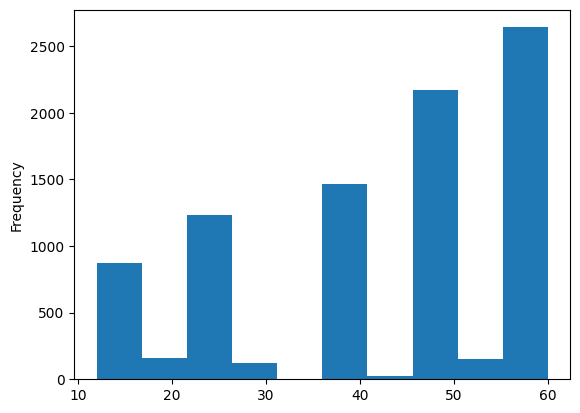

In [26]:
applications_df['Term'].plot.hist()

In [27]:
detect_outliers_iqr(applications_df, 'Term')

{'number_of_outliers': 0, 'outliers': Series([], Name: Term, dtype: int64)}

In [28]:
check_nulls(applications_df, 'Term')

{'number_of_nulls': 0,
 'null_indices': [],
 'null_values': Series([], Name: Term, dtype: int64)}

###  Conclusion:
- Scale and use as is

## Amount

<AxesSubplot: ylabel='Frequency'>

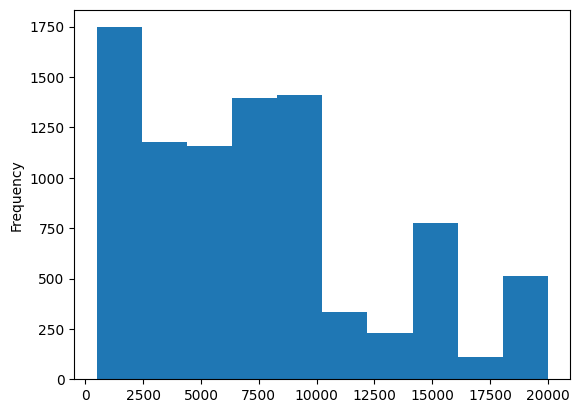

In [29]:
applications_df['Amount'].plot.hist()

In [30]:
detect_outliers_iqr(applications_df, 'Amount')

{'number_of_outliers': 0, 'outliers': Series([], Name: Amount, dtype: int64)}

In [31]:
check_nulls(applications_df, 'Amount')

{'number_of_nulls': 0,
 'null_indices': [],
 'null_values': Series([], Name: Amount, dtype: int64)}

### Conclusion:
- Scale and use as is

## ApplicationDate

I have a hypothesis that there is a correlation between when applications were made and their amount and/or success rate

In [32]:
# Convert ApplicationDate to datetime format
applications_df['ApplicationDate'] = pd.to_datetime(applications_df['ApplicationDate'], format='%d/%m/%Y')

# Extract the month
applications_df['month'] = applications_df['ApplicationDate'].dt.month

In [33]:
applications_df['month']

0        7
1        2
2        8
3        9
4        1
        ..
8842    11
8843    11
8844    11
8845    11
8846    12
Name: month, Length: 8847, dtype: int64

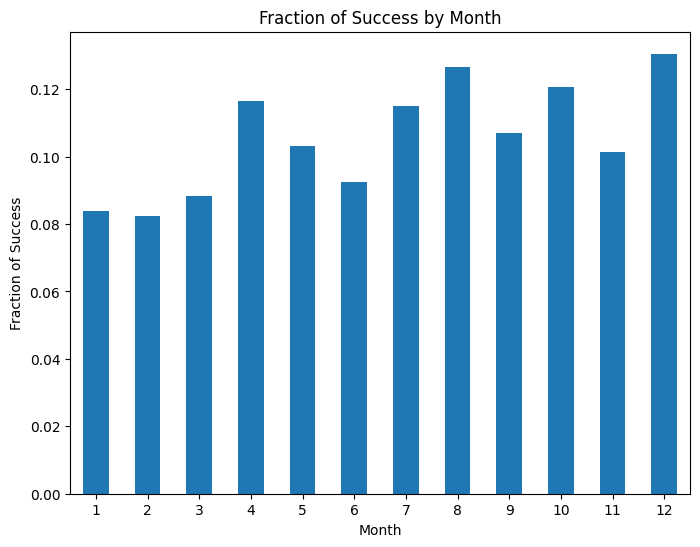

In [34]:
# Check relationship between month and success

# Calculate the fraction of success for each month
success_fraction = applications_df.groupby('month')['Success'].mean()

# Plot the result
plt.figure(figsize=(8, 6))
success_fraction.plot(kind='bar')

plt.title('Fraction of Success by Month')
plt.xlabel('Month')
plt.ylabel('Fraction of Success')
plt.xticks(rotation=0)  # Keep month labels horizontal
plt.show()

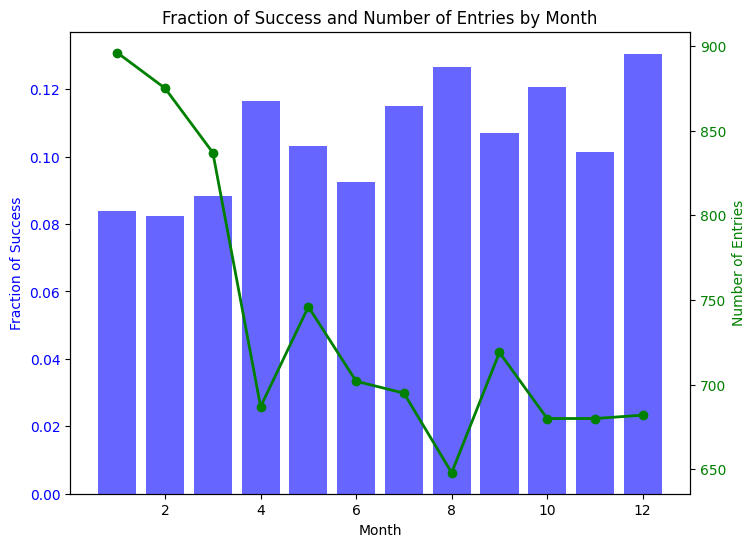

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample dataframe
df = pd.DataFrame({
    'month': [1, 1, 2, 2, 3, 3, 3],
    'success': [1, 0, 1, 0, 1, 1, 0]
})

# Calculate the fraction of success for each month
success_fraction = applications_df.groupby('month')['Success'].mean()

# Calculate the number of entries per month
entries_per_month = applications_df['month'].value_counts().sort_index()

# Create a plot with a secondary y-axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot fraction of success (primary y-axis)
ax1.bar(success_fraction.index, success_fraction, color='blue', alpha=0.6, label='Fraction of Success')
ax1.set_xlabel('Month')
ax1.set_ylabel('Fraction of Success', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for the count of entries
ax2 = ax1.twinx()
ax2.plot(entries_per_month.index, entries_per_month, color='green', marker='o', label='Number of Entries', linewidth=2)
ax2.set_ylabel('Number of Entries', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Title and show plot
plt.title('Fraction of Success and Number of Entries by Month')
plt.show()


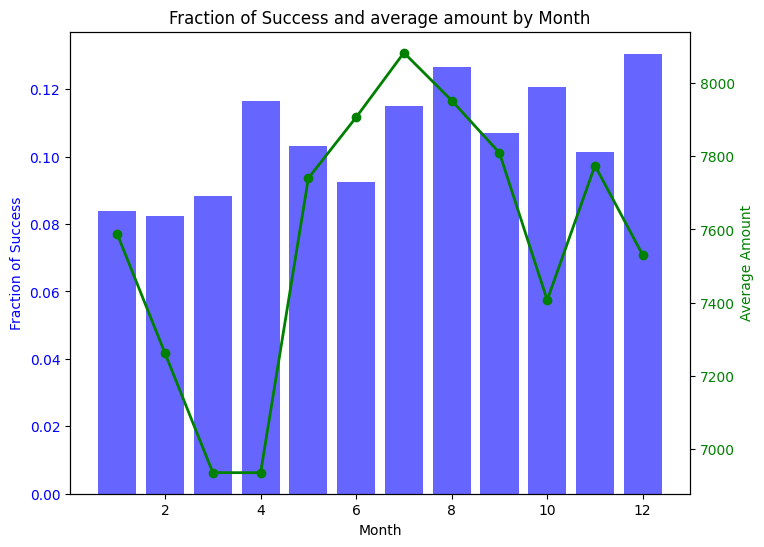

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample dataframe
df = pd.DataFrame({
    'month': [1, 1, 2, 2, 3, 3, 3],
    'success': [1, 0, 1, 0, 1, 1, 0]
})

# Calculate the fraction of success for each month
success_fraction = applications_df.groupby('month')['Success'].mean()

# Calculate the average amount per month
average_amount = applications_df.groupby('month')['Amount'].mean()

# Create a plot with a secondary y-axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot fraction of success (primary y-axis)
ax1.bar(success_fraction.index, success_fraction, color='blue', alpha=0.6, label='Fraction of Success')
ax1.set_xlabel('Month')
ax1.set_ylabel('Fraction of Success', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for the count of entries
ax2 = ax1.twinx()
ax2.plot(average_amount.index, average_amount, color='green', marker='o', label='Average Amount', linewidth=2)
ax2.set_ylabel('Average Amount', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Title and show plot
plt.title('Fraction of Success and average amount by Month')
plt.show()


### Conclusion:
- Do not use

Observations:
- Funny that volume goes down over the course of the year and fraction of successful applications goes up
- Don't know enough about this data to use it.

Reasons for not using:
- do not know if this is an exhaustive list of all applications
- do not know if these applications were approved or rejected by an expert who never makes a mistake or by someone who starts the year feeling mean or by an AI

## Success aka the Target

<AxesSubplot: ylabel='Frequency'>

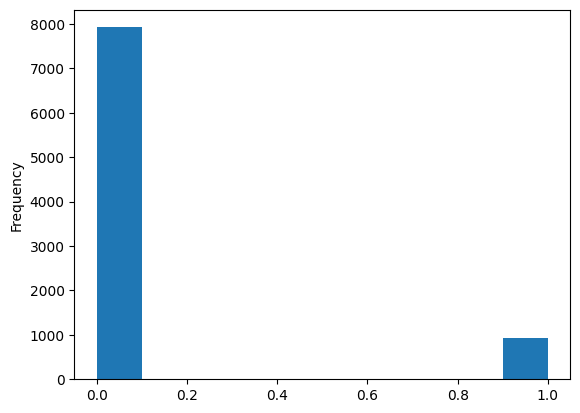

In [37]:
applications_df['Success'].plot.hist()

In [38]:
applications_df['Success'].value_counts()

0    7925
1     922
Name: Success, dtype: int64

In [39]:
# Positive target fraction
pos_target_fraction = applications_df['Success'].value_counts()[1]/applications_df['Success'].value_counts()[0] 

print(f"Positive target ratio = {round(100*pos_target_fraction)} %")

Positive target ratio = 12 %


### Conclusion:

- Imbalanced Dataset
- Sufficient positive class to not need to oversample
- Bear in mind imbalance when evaluating model performance

Deciding whether to lend money: would rather a few extra false negatives than false positives. False positives mean we don't get our money back.

# Check for correlations amongst features

### Separate into numerical, categorical and binary features

In [40]:
# Distinguish between: Numerical features, categorical features, binary-like features
numerical_cols    = applications_df.select_dtypes(include=[np.number]).columns.to_list()
categorical_cols  = applications_df.select_dtypes(exclude=[np.number]).columns.to_list()
binary_variables  = [col for col in numerical_cols if len(applications_df[col].unique())<=3]

numerical_cols = list ( set(numerical_cols)-set(binary_variables))



### Check that categorical and binary features have some correlation with the target

In [41]:
# Test categorical and binary variables against target

chi_test_independent_features_to_drop = []
num_cols = len(categorical_cols)
alpha    = 0.05

for i, var in enumerate(categorical_cols + binary_variables):
        observed = pd.crosstab(applications_df[var], applications_df['Success'])
        chi2, p_val, dof, expected = scs.chi2_contingency(observed, correction=False)
        if p_val > alpha: 
            chi_test_independent_features_to_drop.append(var)

In [42]:
# Features to discard
chi_test_independent_features_to_drop


['LoanPurpose']

### Check independence of numerical features, amongst themselves


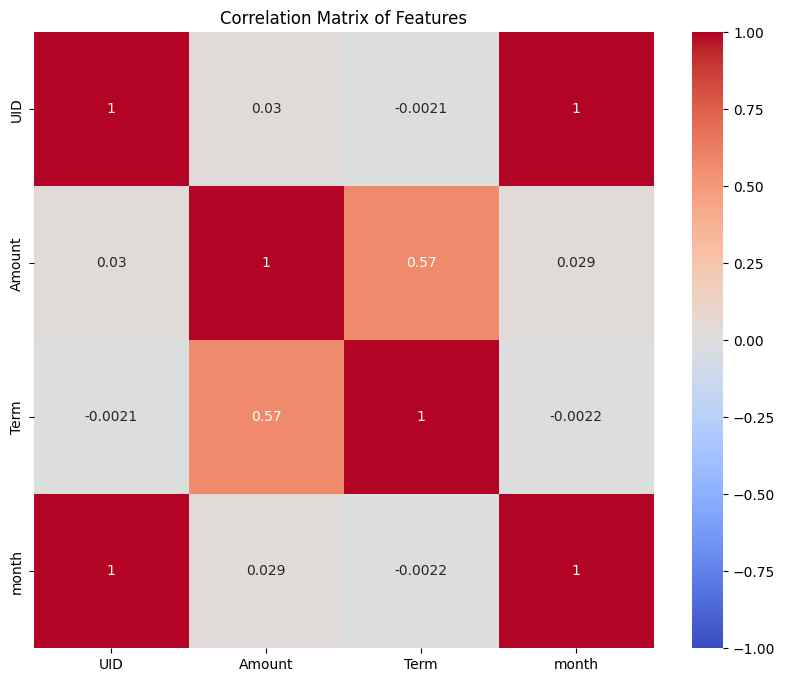

,level_0,level_1,correlation
3,UID,month,0.996007
12,month,UID,0.996007


In [43]:
feature_correlation(applications_df[applications_df.columns.drop('Success')])

### Test independence of categorical features amongst themselves

In [44]:
df = applications_df[categorical_cols].apply( lambda x: x.astype("category") if x.dtype == "O" else x)

In [45]:
cramers_v = am.CramersV(df)

# It will return a pairwise matrix filled with Cramer's V, where 
# columns and index are the categorical variables of the passed pandas.DataFrame
cfit = cramers_v.fit().round(2)

In [46]:
corrmat = cfit

corr_thresh = 0.75
print(' List of cat. vars with Cramers above %.2f' % corr_thresh )
counter = 0
for i in range(0, corrmat.shape[0]-1):
    for j in range(i+1, corrmat.shape[1]):
        if (corrmat.iloc[i,j] > corr_thresh):
            counter+=1
            print( 'Cat. vars show Cramers %.2f: %s AND %s' % (corrmat.iloc[i,j], corrmat.index[i], corrmat.columns[j]) )
print(' Obtained %d couples of highly correlated variables' % counter)



 List of cat. vars with Cramers above 0.75
Cat. vars show Cramers 1.00: LoanPurpose AND purpose
 Obtained 1 couples of highly correlated variables


In [47]:
categorical_features_to_drop = []